# 2.3 Optymalizacja wag w sieci MLP z użyciem algorytmu genetycznego
Zaimplementować proste uczenie MLP z użyciem algorytmu genetycznego. Na wejściu jest: struktura sieci neuronowej i dane uczące. Optymalizowana funkcja to funkcja przekształcająca wektor wag sieci na błąd na zbiorze uczącym. Zastosować standardowe operatory krzyżowania i mutacji.

Przeprowadzić uczenie na zbiorach:

* iris https://archive.ics.uci.edu/ml/datasets/Iris
* multimodal-large (z części laboratorium o sieciach neuronowych)
* auto-mpg (przewidzieć wartość mpg) - http://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [251]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tqdm
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import log_loss

## Sieć MLP 

In [296]:

class MLP:

    def __init__(self, layers, weights, biases, activation = 'sigmoid', output_function='softmax', visualize_weights=False , max_class = None):
        self.layers = copy.deepcopy(layers)
        self.weights = copy.deepcopy(weights)
        self.biases = copy.deepcopy(biases)
        self.max_class = max_class

        self.derivative_w = []
        self.derivative_b = []
        self.visualize_weights = visualize_weights

        if output_function == 'softmax':
            self.function = self.softmax

        elif output_function == 'linear':
            self.function = self.linear
        else : 
            raise ValueError(f'No output function named {output_function} available')
        
        if activation == 'sigmoid':
            self.activation_function = self.sigmoid
            self.grad = self.sigmoidGradient
        elif activation == 'relu' : 
            self.activation_function = self.relu
            self.grad = self.reluGradient
        elif activation =='tanh' : 
            self.activation_function = self.tanh
            self.grad = self.tanhGradient
        elif activation =='linear' : 
            self.activation_function = self.linear
            self.grad = self.linearGradient
            
        

    def forward(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.activations = []
        self.z_values = []

        activations = inputs
        self.activations.append(activations)
        for i in range(len(self.layers) - 2):
            outputs = activations @ self.weights[i] + self.biases[i]
            self.z_values.append(outputs)
            activations = self.activation_function(outputs)
            self.activations.append(activations)

        self.weights[-1].shape
        results = activations @ self.weights[-1] + self.biases[-1]
        self.z_values.append(results)
        activations = self.function(results)
        self.activations.append(activations)
        return activations



    # ------------------------------ ACTIVATIONS ------------------------------ # 
    
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T
    
    @staticmethod
    def relu(x): 
        return np.maximum(x, 0)
    
    @staticmethod
    def tanh(x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    @staticmethod
    def linear(x): 
        return x
    
    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))
     
    # ------------------------------- GRADIENTS ------------------------------- # 
    
    @staticmethod
    def sigmoidGradient(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))
        return sigmoid(x) * (1 - sigmoid(x))
    
    @staticmethod
    def reluGradient(x): 
        return np.where(x > 0, 1, 0)
    
    @staticmethod
    def tanhGradient(x):
        def tanh(x):
            return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        return 1.0 - tanh(x)**2
    
    @staticmethod
    def linearGradient(x):
        return np.ones(x.shape)
    

## Algorytm Genetyczny 

In [286]:
def generate_weights_and_biases(layers, lower, upper):
    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(lower, upper, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(lower, upper, layers[i + 1]).reshape(1, layers[i+1]))

    return weights, biases

def make_flat(weights, biases):
    array_faltten1 = [x.flatten() for x in weights]
    array_faltten2 = [x.flatten() for x in biases]
    
    shapes1 = [x.shape for x in weights]
    shapes2 = [x.shape for x in biases]
    
    x = []
    for element in array_faltten1: 
        x += (list(element))
    for element in array_faltten2: 
        x += (list(element))
    
    return x, shapes1, shapes2

def deflat(x, shapes1, shapes2): 
    shapes = shapes1 + shapes2
    res = [] 
    k = 0
    p = 0
    for i, element in enumerate(shapes): 
        p += element[0]*element[1]
        res.append(np.array(x[k:p]).reshape(shapes[i]))
        k =  p 
    return res[:len(shapes1)], res[len(shapes1):] 

class Genetic: 
    
    def __init__(self, MLP, function,x,  y, activation = 'relu', output_function = 'linear', layers=[1, 5, 5, 1], population_number = 100,  pcross=0.5, pmut = 0.1, ):
        
        mlps = []
        for i in range(population_number):
            weights, biases = generate_weights_and_biases(layers, -1, 1)
            
            mlp = MLP(
                layers, 
                weights,
                biases, 
                activation = activation,
                output_function= output_function
            )
            mlps.append(mlp)
        self.mlp = mlp
        _, self.shapes1, self.shapes2  = make_flat(mlp.weights, mlp.biases) 
        self.chromosomes = [make_flat(mlp.weights, mlp.biases)[0] for mlp in mlps]
        self.pcross = pcross 
        self.pmut = pmut
        self.pupulation_number = population_number
        self.chromosome_size = len(self.chromosomes[0])
        self.function = function
        self.x = x
        self.y = y
        
    def mutate(self, seed = 123): 
        
        chromosomes = np.random.permutation(self.chromosomes)
        number_to_mutate = int(np.floor(self.pmut * len(chromosomes)))
        if number_to_mutate == 0 : 
            return 
        chromosomes_to_mutate = chromosomes[0 : number_to_mutate]
        for i in range(len(chromosomes_to_mutate)):
            chromosomes_to_mutate[i,np.random.randint(0, self.chromosome_size)] += np.random.normal()
            
        chromosomes[0 : number_to_mutate] = chromosomes_to_mutate
        
        self.chromosomes = np.random.permutation(chromosomes)
    
    @staticmethod
    def cross(a,b):
        assert len(a) == len(b)
        
        n = len(a)
        split_point = np.random.randint(1,n-1)
        first_child  = np.append(a[:split_point], b[split_point:])
        second_child = np.append(b[:split_point], a[split_point:])
        
        return first_child, second_child
        
    def pick_best(self, chromosomes):
        
        values = []
        for i, chromosome in enumerate(chromosomes): 
            self.mlp.weights = deflat(chromosome, self.shapes1, self.shapes2)[0]
            self.mlp.biases = deflat(chromosome, self.shapes1, self.shapes2)[1]
            
            val = 1/self.function(self.y, self.mlp.forward(self.x))
            values.append(val)
            
        probs = np.array([val/sum(values) for val in values])
        self.best.append(chromosomes[np.argmax(probs)])
        self.mean.append(np.mean(1/np.array(values)))
        choice = np.random.choice(np.arange(len(chromosomes)), size = len(chromosomes), replace = True, p = probs).astype('int')
        parents = np.array(chromosomes)[choice]
        
        return parents
        
    def evolution(self, iterations = 100):
        self.best = []
        self.mean = [] 
                         
        for i in tqdm.tqdm(range(iterations)):
            chromosomes = np.random.permutation(self.chromosomes)
            parents = self.pick_best(self.chromosomes)
            
            children = []
            while len(children) < len(chromosomes): 
                if self.pcross >= np.random.uniform(0,1): 
                    child1, child2 = self.cross(parents[np.random.randint(len(parents))], parents[np.random.randint(len(parents))])
                    children.append(child1)
                    children.append(child2)
                else: 
                    children.append(parents[np.random.randint(len(parents))])
                
            
            self.chromosomes = np.array(children[:len(chromosomes)])
            self.mutate(self.chromosomes)
        nothing = self.pick_best(self.chromosomes)
        print('---- evolution ended ----')
        self.mlp.weights = deflat(self.best[-1], self.shapes1, self.shapes2)[0]
        self.mlp.biases = deflat(self.best[-1], self.shapes1, self.shapes2)[1]
        res = self.mlp.forward(self.x)
        print(f'best result {self.function(y, res)}')
        



## Test na zbiorach

### multimodal-large

In [220]:
train_df = pd.read_csv('..\data\multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('..\data\multimodal-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)
y = np.asarray(train_df['y']).reshape(-1, 1)
y = (y - np.mean(y, axis = 0))/np.std(y, axis = 0)

x_test = np.asarray(test_df['x']).reshape(-1,1)


layers=[1, 16, 16, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

In [202]:
gen = Genetic(MLP, function = mean_absolute_error, x = x,  y = y, activation = 'sigmoid', output_function = 'linear', layers=[1, 16, 16, 1], population_number = 100,  pcross=0.7, pmut = 0.4)

In [205]:
gen.evolution(1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:14<00:00,  1.09it/s]


---- evolution ended ----
best result 0.23633233540820492


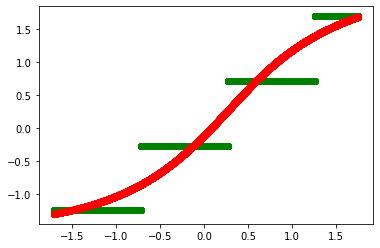

In [206]:
predictions = gen.mlp.forward(x)


plt.scatter(x, y, color='green')
plt.scatter(x, predictions, color='red')
plt.show()

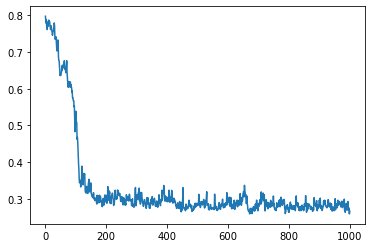

In [215]:
plt.plot(gen.mean) # wartość funkcji dla chromosomów w poszczególnych iteracjach

In [216]:
gen = Genetic(MLP, function = mean_absolute_error, x = x,  y = y, activation = 'relu', output_function = 'linear', layers=[1, 16, 16, 1], population_number = 100,  pcross=0.7, pmut = 0.4)

In [217]:
gen.evolution(200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:40<00:00,  1.99it/s]


---- evolution ended ----
best result 0.16268028393056025


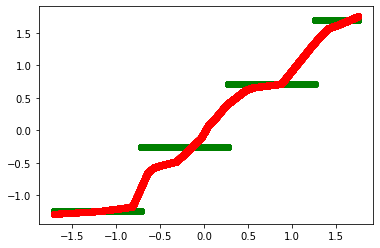

In [221]:
predictions = gen.mlp.forward(x)


plt.scatter(x, y, color='green')
plt.scatter(x, predictions, color='red')
plt.show()

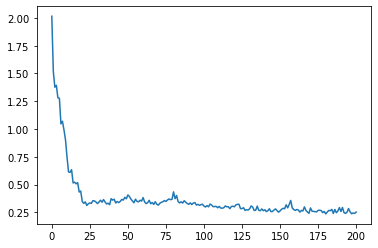

In [222]:
plt.plot(gen.mean) # wartość funkcji dla chromosomów w poszczególnych iteracjach

### Wnioski 
Na zbiorze multimodal, lepiej sprawdziło się relu niż sigmoid. Algorytm genetyczny w miarę dobrze poradził sobie z optymalizacją wyniku. Brakuje jednak precyzji aby powiedzieć, że wykonał zadanie w pełni dobrze. 

## iris

In [239]:
from sklearn.preprocessing import OrdinalEncoder

In [244]:
train_df = pd.read_csv('../data/iris.data', header=None, index_col=0).reset_index()

x = np.asarray(train_df.iloc[:,0:4])
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)

y = np.asarray(train_df.iloc[:,4]).reshape(-1, 1)
y = OrdinalEncoder().fit_transform(y).astype('int')

b = np.zeros((y.size, y.max() + 1))
b[np.arange(y.size), y.flatten()] = 1

In [246]:
gen = Genetic(MLP, function = log_loss, x = x,  y = b, activation = 'relu', output_function = 'softmax', layers=[4, 16, 16, 3], population_number = 100,  pcross=0.7, pmut = 0.4)

In [247]:
gen.evolution(200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.16it/s]

---- evolution ended ----
best result 0.06287758713108171


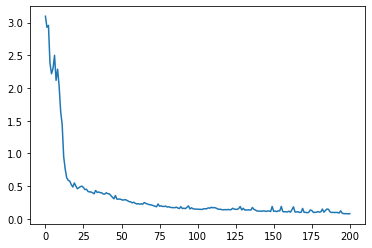

In [248]:
plt.plot(gen.mean)

In [252]:
accuracy_score(np.argmax(gen.mlp.forward(x),axis = 1), y)

0.9666666666666667

### Wnioski 
Tutaj algorytm wykonał zadanie bez zastrzeżeń. Accuracy rzędu 0.97 jest bardzo dobrym wynikiem. 

### auto-mpg

In [297]:
train_df = pd.read_csv('..\data\\auto-mpg.data', sep='\s+', header=None)
train_df = train_df[train_df[3] != "?"]
x = train_df.iloc[:,1:7]
x = x.apply(pd.to_numeric).to_numpy()
x = (x - np.mean(x, axis = 0))/np.std(x, axis = 0)
y = np.asarray(train_df.iloc[:,0]).reshape(-1, 1)




In [298]:
gen = Genetic(MLP, function = mean_absolute_error, x = x,  y = y, activation = 'relu', output_function = 'linear', layers=[6, 16, 16, 1], population_number = 100,  pcross=0.7, pmut = 0.4)

In [299]:
gen.evolution(200)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 32.70it/s]


---- evolution ended ----
best result 2.973502231296537


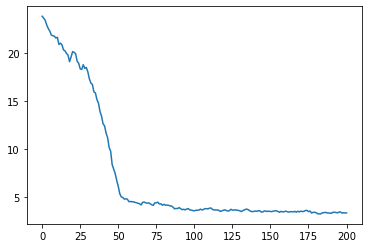

In [300]:
plt.plot(gen.mean)

### Wnioski 
Tutaj również algorytmowi udało się osiągnąć satysfakcjonujący wynik.

# Wnioski globalne 
Algorytm genetyczny dobrze aproksymuje optymalne rozwiązanie. Najlepiej sprawdzała się funkcja `relu`. Również normalizacja wag była kluczowa dla dobrego działania algorytmu, co nie powinno dziwić, jeśli początkowo wagi losujemy z rozkładu normalnego o wartości oczekiwanej 0.  